In [ ]:
import MetaTrader5 as mt5
import time

# Initialize connection to MetaTrader 5
mt5.initialize()

# Login to your account
account_number = 12345678  # replace with your account number
password = "your_password"  # replace with your account password
server = "your_broker_server"  # replace with your broker server

if not mt5.login(account_number, password, server):
    print("Failed to connect at account #{}, error code: {}".format(account_number, mt5.last_error()))
    quit()

# Set the symbol you want to trade
symbol = "EURUSD"
lot_size = 0.1
hedge_lot_size = lot_size * 1.4
entry_pips = 50
hedge_pips = 150

def place_order(symbol, order_type, lot, price, stop_loss, take_profit):
    point = mt5.symbol_info(symbol).point
    deviation = 20
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot,
        "type": order_type,
        "price": price,
        "sl": stop_loss,
        "tp": take_profit,
        "deviation": deviation,
        "magic": 234000,
        "comment": "python script order",
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_RETURN,
    }
    result = mt5.order_send(request)
    return result

def get_price(symbol):
    return mt5.symbol_info_tick(symbol).bid, mt5.symbol_info_tick(symbol).ask

def hedge_strategy():
    initial_trade = place_order(symbol, mt5.ORDER_TYPE_BUY, lot_size, get_price(symbol)[1], 0, 0)
    if initial_trade.retcode != mt5.TRADE_RETCODE_DONE:
        print("Initial trade failed, error code: ", initial_trade.retcode)
        return

    while True:
        bid, ask = get_price(symbol)
        current_price = (bid + ask) / 2

        if current_price <= initial_trade.price - (entry_pips * mt5.symbol_info(symbol).point):
            place_order(symbol, mt5.ORDER_TYPE_SELL, hedge_lot_size, bid, 0, 0)
            print("Hedge trade placed")
            time.sleep(1)
            break

        time.sleep(1)

# Start hedging strategy
hedge_strategy()

# Shutdown connection to MetaTrader 5
mt5.shutdown()


In [ ]:
import MetaTrader5 as mt5
import pandas as pd
import datetime

# Initialize connection to MetaTrader 5
mt5.initialize()

# Login to your account
account_number = 12345678  # replace with your account number
password = "your_password"  # replace with your account password
server = "your_broker_server"  # replace with your broker server

if not mt5.login(account_number, password, server):
    print("Failed to connect at account #{}, error code: {}".format(account_number, mt5.last_error()))
    quit()

# Set the symbol and time frame for backtesting
symbol = "EURUSD"
time_frame = mt5.TIMEFRAME_H1
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime(2023, 1, 1)

# Get historical data
rates = mt5.copy_rates_range(symbol, time_frame, start_date, end_date)
mt5.shutdown()

# Convert to DataFrame
data = pd.DataFrame(rates)
data['time'] = pd.to_datetime(data['time'], unit='s')

# Strategy parameters
initial_lot = 1.0
hedge_lot_factor = 1.4
entry_pips = 50
hedge_pips = 150
point = mt5.symbol_info(symbol).point

# Backtest the strategy
initial_trade_opened = False
initial_trade_price = 0
initial_lot_size = 0
trades = []

for i, row in data.iterrows():
    if not initial_trade_opened:
        # Open initial trade
        initial_trade_opened = True
        initial_trade_price = row['close']
        initial_lot_size = initial_lot
        trades.append({'type': 'buy', 'price': initial_trade_price, 'lot': initial_lot_size, 'time': row['time']})
    else:
        current_price = row['close']
        if current_price <= initial_trade_price - (entry_pips * point):
            # Open hedge trade
            hedge_lot_size = initial_lot_size * hedge_lot_factor
            trades.append({'type': 'sell', 'price': current_price, 'lot': hedge_lot_size, 'time': row['time']})
            break

# Calculate the profit/loss
pnl = 0
for trade in trades:
    if trade['type'] == 'buy':
        pnl += (current_price - trade['price']) * trade['lot']
    else:
        pnl += (trade['price'] - current_price) * trade['lot']

print(f"Profit/Loss: {pnl}")

# Optionally, you can save the trades and data to a CSV file for further analysis
trades_df = pd.DataFrame(trades)
trades_df.to_csv('trades.csv', index=False)
data.to_csv('historical_data.csv', index=False)


In [1]:
initial_lot_size = 1
buy_lots = [1, 1, 1.9, 3.3]
sell_lots = [1.4, 1.4, 2.5, 4.4]
pip_tp = 60
pip_step = 20

trades = []
initial_price = get_current_price()

# Place initial buy trade
trades.append(place_trade('buy', initial_lot_size, initial_price, pip_tp))

while True:
    current_price = get_current_price()
    
    # Check if any trade hit TP
    for trade in trades:
        if has_hit_tp(trade, current_price):
            close_all_trades(trades)
            trades.clear()
            initial_price = current_price
            trades.append(place_trade('buy', initial_lot_size, initial_price, pip_tp))
            break
    
    # Place new trades if necessary
    if len(trades) < 9:
        last_trade = trades[-1]
        if last_trade['type'] == 'buy' and current_price <= last_trade['price'] - pip_step:
            new_lot_size = sell_lots[(len(trades) - 1) // 2]
            trades.append(place_trade('sell', new_lot_size, current_price, pip_tp))
        elif last_trade['type'] == 'sell' and current_price >= last_trade['price'] + pip_step:
            new_lot_size = buy_lots[len(trades) // 2]
            trades.append(place_trade('buy', new_lot_size, current_price, pip_tp))

# Define helper functions
def place_trade(trade_type, lot_size, price, tp):
    # Place a trade with the specified parameters and return trade details
    pass

def get_current_price():
    # Fetch the current market price
    pass

def has_hit_tp(trade, current_price):
    # Check if the trade has hit its TP
    pass

def close_all_trades(trades):
    # Close all open trades
    pass


NameError: name 'get_current_price' is not defined

In [2]:
import pandas as pd
import backtrader as bt
import datetime

# Load historical data
data = pd.read_csv('historical_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

class HedgingStrategy(bt.Strategy):
    def __init__(self):
        self.trade_count = 0
        self.open_trades = []
        self.initial_price = None

    def next(self):
        if self.trade_count == 0:
            self.initial_price = self.data.close[0]
            self.buy(size=1)
            self.trade_count += 1
            self.open_trades.append(('buy', self.data.close[0], 1))
        else:
            last_trade = self.open_trades[-1]
            if last_trade[0] == 'buy' and self.data.close[0] <= last_trade[1] - 20:
                self.sell(size=1.4)
                self.trade_count += 1
                self.open_trades.append(('sell', self.data.close[0], 1.4))
            elif last_trade[0] == 'sell' and self.data.close[0] >= last_trade[1] + 20:
                self.buy(size=1)
                self.trade_count += 1
                self.open_trades.append(('buy', self.data.close[0], 1))

            for trade in self.open_trades:
                if trade[0] == 'buy' and self.data.close[0] >= trade[1] + 60:
                    self.close_all_trades()
                    break
                elif trade[0] == 'sell' and self.data.close[0] <= trade[1] - 60:
                    self.close_all_trades()
                    break

    def close_all_trades(self):
        for trade in self.open_trades:
            if trade[0] == 'buy':
                self.sell(size=trade[2])
            else:
                self.buy(size=trade[2])
        self.open_trades = []
        self.trade_count = 0

# Initialize Backtrader
cerebro = bt.Cerebro()

# Add data feed to Cerebro
data_feed = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data_feed)

# Add strategy to Cerebro
cerebro.addstrategy(HedgingStrategy)

# Set initial cash
cerebro.broker.setcash(10000)

# Set commission
cerebro.broker.setcommission(commission=0.001)

# Run backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Plot the result
cerebro.plot()


FileNotFoundError: [Errno 2] No such file or directory: 'historical_data.csv'

In [ ]:
import pandas as pd
import backtrader as bt

# Load historical data
data = pd.read_csv('historical_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

class HedgingStrategy(bt.Strategy):
    params = (
        ('pip_tp', 60),
        ('pip_step', 20),
        ('buy_lots', [1, 1, 1.9, 3.3]),
        ('sell_lots', [1.4, 2.5, 4.4]),
    )

    def __init__(self):
        self.trade_count = 0
        self.open_trades = []
        self.initial_price = None

    def next(self):
        current_price = self.data.close[0]
        if self.trade_count == 0:
            self.initial_price = current_price
            self.buy(size=self.params.buy_lots[0])
            self.trade_count += 1
            self.open_trades.append(('buy', current_price, self.params.buy_lots[0]))
        else:
            last_trade = self.open_trades[-1]
            if last_trade[0] == 'buy' and current_price <= last_trade[1] - self.params.pip_step:
                size = self.params.sell_lots[min(len(self.open_trades) // 2, len(self.params.sell_lots) - 1)]
                self.sell(size=size)
                self.trade_count += 1
                self.open_trades.append(('sell', current_price, size))
            elif last_trade[0] == 'sell' and current_price >= last_trade[1] + self.params.pip_step:
                size = self.params.buy_lots[min(len(self.open_trades) // 2, len(self.params.buy_lots) - 1)]
                self.buy(size=size)
                self.trade_count += 1
                self.open_trades.append(('buy', current_price, size))

            for trade in self.open_trades:
                if trade[0] == 'buy' and current_price >= trade[1] + self.params.pip_tp:
                    self.close_all_trades()
                    break
                elif trade[0] == 'sell' and current_price <= trade[1] - self.params.pip_tp:
                    self.close_all_trades()
                    break

    def close_all_trades(self):
        for trade in self.open_trades:
            if trade[0] == 'buy':
                self.sell(size=trade[2])
            else:
                self.buy(size=trade[2])
        self.open_trades = []
        self.trade_count = 0

# Initialize Backtrader
cerebro = bt.Cerebro()

# Add data feed to Cerebro
data_feed = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data_feed)

# Add strategy to Cerebro
cerebro.addstrategy(HedgingStrategy)

# Set initial cash
cerebro.broker.setcash(10000)

# Set commission
cerebro.broker.setcommission(commission=0.001)

# Run backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Plot the result
cerebro.plot()


[*********************100%%**********************]  1 of 1 completed
C:\Users\NOC\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Starting Portfolio Value: 10000.00
Ending Portfolio Value: 9998.96


<IPython.core.display.Javascript object>


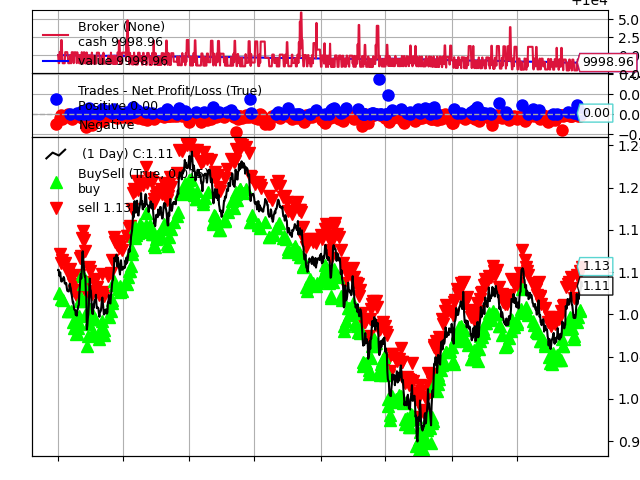

[[<Figure size 640x480 with 4 Axes>]]

In [3]:
import pandas as pd
import yfinance as yf
import backtrader as bt
import datetime

# Fetch historical data
ticker = "EURUSD=X"
data = yf.download(ticker, start="2020-01-01", end="2024-01-01")

# Format the data
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)

class HedgingStrategy(bt.Strategy):
    params = (
        ('pip_tp', 0.0060),  # Approx. 60 pips
        ('pip_step', 0.0020),  # Approx. 20 pips
        ('buy_lots', [1, 1, 1.9, 3.3]),
        ('sell_lots', [1.4, 2.5, 4.4]),
    )

    def __init__(self):
        self.trade_count = 0
        self.open_trades = []
        self.initial_price = None

    def next(self):
        current_price = self.data.close[0]
        if self.trade_count == 0:
            self.initial_price = current_price
            self.buy(size=self.params.buy_lots[0])
            self.trade_count += 1
            self.open_trades.append(('buy', current_price, self.params.buy_lots[0]))
        else:
            last_trade = self.open_trades[-1]
            if last_trade[0] == 'buy' and current_price <= last_trade[1] - self.params.pip_step:
                size = self.params.sell_lots[min(len(self.open_trades) // 2, len(self.params.sell_lots) - 1)]
                self.sell(size=size)
                self.trade_count += 1
                self.open_trades.append(('sell', current_price, size))
            elif last_trade[0] == 'sell' and current_price >= last_trade[1] + self.params.pip_step:
                size = self.params.buy_lots[min(len(self.open_trades) // 2, len(self.params.buy_lots) - 1)]
                self.buy(size=size)
                self.trade_count += 1
                self.open_trades.append(('buy', current_price, size))

            for trade in self.open_trades:
                if trade[0] == 'buy' and current_price >= trade[1] + self.params.pip_tp:
                    self.close_all_trades()
                    break
                elif trade[0] == 'sell' and current_price <= trade[1] - self.params.pip_tp:
                    self.close_all_trades()
                    break

    def close_all_trades(self):
        for trade in self.open_trades:
            if trade[0] == 'buy':
                self.sell(size=trade[2])
            else:
                self.buy(size=trade[2])
        self.open_trades = []
        self.trade_count = 0

# Initialize Backtrader
cerebro = bt.Cerebro()

# Add data feed to Cerebro
data_feed = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data_feed)

# Add strategy to Cerebro
cerebro.addstrategy(HedgingStrategy)

# Set initial cash
cerebro.broker.setcash(10000)

# Set commission
cerebro.broker.setcommission(commission=0.001)

# Run backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Plot the result
cerebro.plot()


In [6]:
import pandas as pd
import yfinance as yf
import backtrader as bt
import datetime
from backtrader.analyzers import TradeAnalyzer, DrawDown

# Fetch historical data
ticker = "GBPUSD=X"
data = yf.download(ticker, start="2020-01-01", end="2024-01-01")

# Format the data
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)

class HedgingStrategy(bt.Strategy):
    params = (
        ('pip_tp', 0.0060),  # Approx. 60 pips
        ('pip_step', 0.0020),  # Approx. 20 pips
        ('buy_lots', [1, 1, 1.9, 3.3]),
        ('sell_lots', [1.4, 1.4, 2.5, 4.4]),
    )

    def __init__(self):
        self.trade_count = 0
        self.open_trades = []
        self.initial_price = None
        self.long_count = 0
        self.short_count = 0
        self.consecutive_wins = 0
        self.consecutive_losses = 0
        self.max_consecutive_wins = 0
        self.max_consecutive_losses = 0

    def next(self):
        current_price = self.data.close[0]
        if self.trade_count == 0:
            self.initial_price = current_price
            self.buy(size=self.params.buy_lots[0])
            self.trade_count += 1
            self.long_count += 1
            self.open_trades.append(('buy', current_price, self.params.buy_lots[0]))
        else:
            last_trade = self.open_trades[-1]
            if last_trade[0] == 'buy' and current_price <= last_trade[1] - self.params.pip_step:
                size = self.params.sell_lots[min(len(self.open_trades) // 2, len(self.params.sell_lots) - 1)]
                self.sell(size=size)
                self.trade_count += 1
                self.short_count += 1
                self.open_trades.append(('sell', current_price, size))
            elif last_trade[0] == 'sell' and current_price >= last_trade[1] + self.params.pip_step:
                size = self.params.buy_lots[min(len(self.open_trades) // 2, len(self.params.buy_lots) - 1)]
                self.buy(size=size)
                self.trade_count += 1
                self.long_count += 1
                self.open_trades.append(('buy', current_price, size))

            for trade in self.open_trades:
                if trade[0] == 'buy' and current_price >= trade[1] + self.params.pip_tp:
                    self.close_all_trades(profit=True)
                    break
                elif trade[0] == 'sell' and current_price <= trade[1] - self.params.pip_tp:
                    self.close_all_trades(profit=True)
                    break

    def close_all_trades(self, profit):
        for trade in self.open_trades:
            if trade[0] == 'buy':
                self.sell(size=trade[2])
            else:
                self.buy(size=trade[2])
        
        if profit:
            self.consecutive_wins += 1
            self.consecutive_losses = 0
        else:
            self.consecutive_wins = 0
            self.consecutive_losses += 1
        
        self.max_consecutive_wins = max(self.max_consecutive_wins, self.consecutive_wins)
        self.max_consecutive_losses = max(self.max_consecutive_losses, self.consecutive_losses)
        
        self.open_trades = []
        self.trade_count = 0

# Initialize Backtrader
cerebro = bt.Cerebro()

# Add data feed to Cerebro
data_feed = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data_feed)

# Add strategy to Cerebro
cerebro.addstrategy(HedgingStrategy)

# Set initial cash
cerebro.broker.setcash(10000)

# Set commission
cerebro.broker.setcommission(commission=0.001)

# Add analyzers
cerebro.addanalyzer(TradeAnalyzer, _name="trade_analyzer")
cerebro.addanalyzer(DrawDown, _name="drawdown")

# Run backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Extracting the analyzers
trade_analyzer = results[0].analyzers.trade_analyzer.get_analysis()
drawdown_analyzer = results[0].analyzers.drawdown.get_analysis()

# Display results
print("\nTrade Analysis Results:")
print(f"Total Trades: {trade_analyzer.total.closed}")
print(f"Total Long Trades: {results[0].long_count}")
print(f"Total Short Trades: {results[0].short_count}")
print(f"Consecutive Wins: {results[0].max_consecutive_wins}")
print(f"Consecutive Losses: {results[0].max_consecutive_losses}")
print(f"Net Profit: {trade_analyzer.pnl.net.total}")
print(f"Max Drawdown: {drawdown_analyzer.max.drawdown}")
print(f"Relative Drawdown: {drawdown_analyzer.max.drawdown / cerebro.broker.startingcash * 100:.2f}%")

# Plot the result
cerebro.plot()


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['XAUUSD=X']: Exception('%ticker%: No timezone found, symbol may be delisted')


Starting Portfolio Value: 10000.00
Ending Portfolio Value: 10000.00

Trade Analysis Results:


KeyError: 

[*********************100%%**********************]  1 of 1 completed
C:\Users\NOC\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Starting Portfolio Value: 10000.00
Ending Portfolio Value: 9999.00

Trade Analysis Results:
Total Trades: 493
Total Long Trades: 1
Total Short Trades: 0
Consecutive Wins: 164
Consecutive Losses: 0
Net Profit: -1.001120619535449
Max Drawdown: 0.010212226913099585
Relative Drawdown: 0.00%


<IPython.core.display.Javascript object>


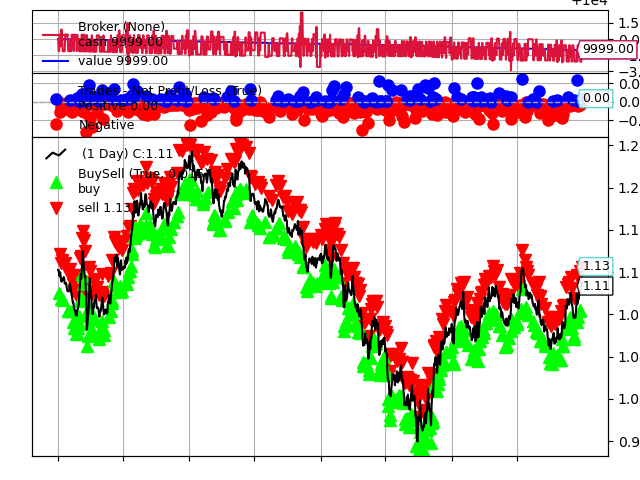

[[<Figure size 640x480 with 4 Axes>]]

In [7]:
import pandas as pd
import yfinance as yf
import backtrader as bt
import datetime
from backtrader.analyzers import TradeAnalyzer, DrawDown

# Fetch historical data
ticker = "EURUSD=X"
data = yf.download(ticker, start="2020-01-01", end="2024-01-01")

# Format the data
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)

class HedgingStrategy(bt.Strategy):
    params = (
        ('pip_tp', 0.0060),  # Approx. 60 pips
        ('pip_step', 0.0020),  # Approx. 20 pips
        ('buy_lots', [1, 1, 1.9, 3.3]),
        ('sell_lots', [1.4, 1.4, 2.5, 4.4]),
    )

    def __init__(self):
        self.trade_count = 0
        self.open_trades = []
        self.initial_price = None
        self.long_count = 0
        self.short_count = 0
        self.consecutive_wins = 0
        self.consecutive_losses = 0
        self.max_consecutive_wins = 0
        self.max_consecutive_losses = 0

    def next(self):
        current_price = self.data.close[0]
        if self.trade_count == 0:
            self.initial_price = current_price
            self.buy(size=self.params.buy_lots[0])
            self.trade_count += 1
            self.long_count += 1
            self.open_trades.append(('buy', current_price, self.params.buy_lots[0]))
        else:
            last_trade = self.open_trades[-1]
            if last_trade[0] == 'buy' and current_price <= last_trade[1] - self.params.pip_step and self.short_count < len(self.params.sell_lots):
                size = self.params.sell_lots[self.short_count]
                self.sell(size=size)
                self.trade_count += 1
                self.short_count += 1
                self.open_trades.append(('sell', current_price, size))
            elif last_trade[0] == 'sell' and current_price >= last_trade[1] + self.params.pip_step and self.long_count < len(self.params.buy_lots):
                size = self.params.buy_lots[self.long_count]
                self.buy(size=size)
                self.trade_count += 1
                self.long_count += 1
                self.open_trades.append(('buy', current_price, size))

            for trade in self.open_trades:
                if trade[0] == 'buy' and current_price >= trade[1] + self.params.pip_tp:
                    self.close_all_trades(profit=True)
                    break
                elif trade[0] == 'sell' and current_price <= trade[1] - self.params.pip_tp:
                    self.close_all_trades(profit=True)
                    break

    def close_all_trades(self, profit):
        for trade in self.open_trades:
            if trade[0] == 'buy':
                self.sell(size=trade[2])
            else:
                self.buy(size=trade[2])
        
        if profit:
            self.consecutive_wins += 1
            self.consecutive_losses = 0
        else:
            self.consecutive_wins = 0
            self.consecutive_losses += 1
        
        self.max_consecutive_wins = max(self.max_consecutive_wins, self.consecutive_wins)
        self.max_consecutive_losses = max(self.max_consecutive_losses, self.consecutive_losses)
        
        self.open_trades = []
        self.trade_count = 0
        self.long_count = 0
        self.short_count = 0

# Initialize Backtrader
cerebro = bt.Cerebro()

# Add data feed to Cerebro
data_feed = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data_feed)

# Add strategy to Cerebro
cerebro.addstrategy(HedgingStrategy)

# Set initial cash
cerebro.broker.setcash(10000)

# Set commission
cerebro.broker.setcommission(commission=0.001)

# Add analyzers
cerebro.addanalyzer(TradeAnalyzer, _name="trade_analyzer")
cerebro.addanalyzer(DrawDown, _name="drawdown")

# Run backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Extracting the analyzers
trade_analyzer = results[0].analyzers.trade_analyzer.get_analysis()
drawdown_analyzer = results[0].analyzers.drawdown.get_analysis()

# Display results
print("\nTrade Analysis Results:")
print(f"Total Trades: {trade_analyzer.total.closed}")
print(f"Total Long Trades: {results[0].long_count}")
print(f"Total Short Trades: {results[0].short_count}")
print(f"Consecutive Wins: {results[0].max_consecutive_wins}")
print(f"Consecutive Losses: {results[0].max_consecutive_losses}")
print(f"Net Profit: {trade_analyzer.pnl.net.total}")
print(f"Max Drawdown: {drawdown_analyzer.max.drawdown}")
print(f"Relative Drawdown: {drawdown_analyzer.max.drawdown / cerebro.broker.startingcash * 100:.2f}%")

# Plot the result
cerebro.plot()


In [5]:
import pandas as pd
import yfinance as yf
from backtesting import Backtest, Strategy

# Fetch historical data
ticker = "GBPUSD=X"
data = yf.download(ticker, start="2020-01-01", end="2024-06-06")

# Format the data
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.rename(columns={'Open': 'Open', 'High': 'High', 'Low': 'Low', 'Close': 'Close', 'Volume': 'Volume'}, inplace=True)

# Calculate signals (here, it's a simple placeholder; replace with actual signal logic)
data['signal'] = 0
data.loc[data['Close'] > data['Close'].shift(1), 'signal'] = 1
data.loc[data['Close'] < data['Close'].shift(1), 'signal'] = 2

# Define your strategy
class HedgingStrategy(Strategy):
    pip_tp = 0.0060  # Approx. 60 pips
    pip_step = 0.0020  # Approx. 20 pips
    buy_lots = [0.01, 0.01, 0.019, 0.033]  # Adjusted to be fractions
    sell_lots = [0.014, 0.014, 0.025, 0.044]  # Adjusted to be fractions

    def init(self):
        self.signal = self.data.signal
        self.trade_count = 0
        self.open_trades = []
        self.initial_price = None
        self.long_count = 0
        self.short_count = 0
        self.consecutive_wins = 0
        self.consecutive_losses = 0
        self.max_consecutive_wins = 0
        self.max_consecutive_losses = 0

    def next(self):
        current_price = self.data.Close[-1]
        signal = self.signal[-1]

        if self.trade_count == 0:
            self.initial_price = current_price
            if signal == 1:
                self.buy(size=self.buy_lots[0])
                self.long_count += 1
                self.open_trades.append(('buy', current_price, self.buy_lots[0]))
            elif signal == 2:
                self.sell(size=self.sell_lots[0])
                self.short_count += 1
                self.open_trades.append(('sell', current_price, self.sell_lots[0]))
            self.trade_count += 1

        else:
            last_trade = self.open_trades[-1]
            if last_trade[0] == 'buy' and current_price <= last_trade[1] - self.pip_step and self.short_count < len(self.sell_lots):
                size = self.sell_lots[self.short_count]
                self.sell(size=size)
                self.trade_count += 1
                self.short_count += 1
                self.open_trades.append(('sell', current_price, size))
            elif last_trade[0] == 'sell' and current_price >= last_trade[1] + self.pip_step and self.long_count < len(self.buy_lots):
                size = self.buy_lots[self.long_count]
                self.buy(size=size)
                self.trade_count += 1
                self.long_count += 1
                self.open_trades.append(('buy', current_price, size))

            for trade in self.open_trades:
                if trade[0] == 'buy' and current_price >= trade[1] + self.pip_tp:
                    self.close_all_trades(profit=True)
                    break
                elif trade[0] == 'sell' and current_price <= trade[1] - self.pip_tp:
                    self.close_all_trades(profit=True)
                    break

    def close_all_trades(self, profit):
        for trade in self.open_trades:
            if trade[0] == 'buy':
                self.sell(size=trade[2])
            else:
                self.buy(size=trade[2])
        
        if profit:
            self.consecutive_wins += 1
            self.consecutive_losses = 0
        else:
            self.consecutive_wins = 0
            self.consecutive_losses += 1
        
        self.max_consecutive_wins = max(self.max_consecutive_wins, self.consecutive_wins)
        self.max_consecutive_losses = max(self.max_consecutive_losses, self.consecutive_losses)
        
        self.open_trades = []
        self.trade_count = 0
        self.long_count = 0
        self.short_count = 0

# Backtest using the Backtesting library
print("Running backtest...")
bt = Backtest(data, HedgingStrategy, cash=10_000, commission=0.001)
results = bt.run()
print("Backtest complete.")
print(results)

bt.plot()


[*********************100%%**********************]  1 of 1 completed
C:\Users\NOC\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Running backtest...
Backtest complete.
Start                     2020-01-01 00:00:00
End                       2023-12-29 00:00:00
Duration                   1458 days 00:00:00
Exposure Time [%]                   99.808245
Equity Final [$]                  9950.294812
Equity Peak [$]                  10126.882934
Return [%]                          -0.497052
Buy & Hold Return [%]               -3.985744
Return (Ann.) [%]                    -0.12032
Volatility (Ann.) [%]                0.649887
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -1.941006
Avg. Drawdown [%]                   -0.177308
Max. Drawdown Duration      768 days 00:00:00
Avg. Drawdown Duration       68 days 00:00:00
# Trades                                  981
Win Rate [%]                        44.648318
Best Trade [%]                       6.602338
Worst Trade [%]                     -7.89

Row(id='2098', ...)